# Домашнее задание к занятию «Тематическое моделирование»

### Цель: 
Обобщить и научиться применять полученные знания в NLP для решения задач классификации текста
### Задание:  
Классифицировать по тональности отзывы на банки с сайта banki.ru
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5
1. Анализ текста  
1.1. Посчитайте количество отзывов в разных городах и на разные банки  
1.2. Постройте гистограмы длин ~~слов~~ **(текстов ???)** в символах и в словах  
1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных  
1.4. Постройте кривые Ципфа и Хипса  
1.5. Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и "доверие"?  
1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)  
2. Тематическое моделирование  
2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем  
2.2. Приведите примеры понятных (интерпретируемых) тем  
2.3. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать /
объяснить?  
3. Классификация текстов  
Будем классифицировать на два класса, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)  
3.1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое  
3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.   
3.3. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием 
символьных $n$-грам.  
3.4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:  
1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),  
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).  
3.5. Используйте accuracy и F-measure для оценки качества классификации.

In [1]:
import time
start_time = time.time()

In [2]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
#%pylab inline

In [4]:
pwd

'C:\\Users\\grebe\\Documents\\EDUCATION\\Машинное обучение фундаментальные инструменты и практики\\Обработка естественного языка\\Тематическое моделирование'

In [5]:
#responses = []
#with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
#    for row in tqdm(thefile):
#        resp = json.loads(row)
#        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
#            responses.append(resp)

In [6]:
# if the file is not archived
responses = []
with open('banki_responses.json', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:13, 14705.86it/s]


In [7]:
responses[5]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Не тут-то было...',
 'num_comments': 0,
 'bank_license': 'лицензия № 606',
 'author': 'bankir76',
 'bank_name': 'Гагаринский',
 'datetime': '2015-06-05 11:37:31',
 'text': 'Я, как и многие вкладчики открыл на 1000 руб. со счастливой мыслью пополнить в последствии... Как говорится не тут-то было.  8% за внесение и никакого нарушения договора (сразу вспоминается: "ловкость рук ...". Совершенно непонятно куда в такой ситуации смотрит ЦБ! Ну и абстрактно предлагаю представить следующее: взяв кредит в этом месте (банк здесь слово неуместное) в январе, процентов под 40, вы приходите сегодня вносить очередной платеж и просите добавить вам к вашей сумме процентов эдак 20, ну действительно, почему нет, ситуация-то изменилась...',
 'rating_grade': None}

### 1. Анализ текста

In [8]:
df = pd.DataFrame(responses, columns = ['city', 'bank_name', 'rating_grade', 'text'])

In [9]:
df.head()

,city,bank_name,rating_grade,text
0,г. Москва,Бинбанк,NaN,Добрый день! Я не являюсь клиентом банка и пор...
1,г. Новосибирск,Сбербанк России,NaN,Доброго дня! Являюсь держателем зарплатной кар...
2,г. Москва,Бинбанк,NaN,Здравствуйте! Дублирую свое заявление от 03.0...
3,г. Ставрополь,Сбербанк России,NaN,Добрый день!! Я открыл расчетный счет в СберБа...
4,г. Челябинск,ОТП Банк,NaN,"04.03.2015 г. взяла кредит в вашем банке, заяв..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city          138325 non-null  object 
 1   bank_name     153499 non-null  object 
 2   rating_grade  88658 non-null   float64
 3   text          153499 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.7+ MB


##### 1.1. Посчитайте количество отзывов в разных городах и на разные банки 

In [11]:
df.groupby(['city', 'bank_name'], as_index=False)\
    .count()\
    .sort_values('text', ascending=False)\
    .rename(columns = {'text':'N_comments'})\
    .reset_index()[['city', 'bank_name','N_comments']]

,city,bank_name,N_comments
0,г. Москва,Сбербанк России,8146
1,г. Москва,Альфа-Банк,3871
2,г. Москва,Русский Стандарт,2801
3,г. Москва,ВТБ 24,2714
4,г. Санкт-Петербург,Сбербанк России,2434
...,...,...,...
18764,"г. Москва, Отделение ""Жулебинское""",Московский Кредитный Банк,1
18765,"г. Москва, ""Китай-город""",Фора-Банк,1
18766,"г. Москва, Ветошный пер",Восточный Экспресс Банк,1
18767,"г. Москва, Видное",Сбербанк России,1


##### 1.2. Постройте гистограмы длин ~~слов~~ **(текстов ???)** в символах и в словах  

In [12]:
len_data = df.text.apply(len)
length = len_data.tolist()

print('max length =',max(length),'\n''min length =',min(length))

max length = 32082 
min length = 23


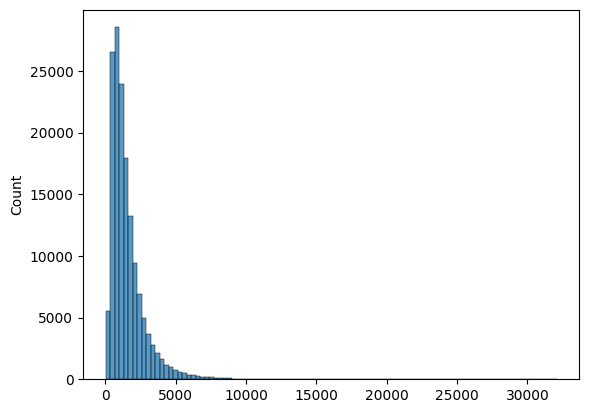

In [13]:
sns.histplot(length, bins=100)
plt.show()

In [14]:
import re
regex = re.compile("[А-Яа-я]+")

In [15]:
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [16]:
df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

In [17]:
df.text[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [18]:
from nltk.tokenize import WordPunctTokenizer
wpt = WordPunctTokenizer()

In [19]:
def token_apply(text):
    return wpt.tokenize(text)

In [20]:
%%time
df['text_only_words'] = df.text.apply(token_apply)

CPU times: total: 14 s
Wall time: 25.4 s


In [21]:
len_data = df.text_only_words.apply(len)
length = len_data.tolist()

print('max length =',max(length),'\n''min length =',min(length))

max length = 5001 
min length = 0


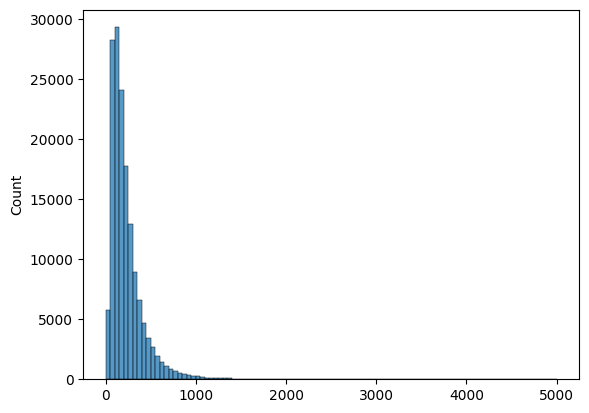

In [22]:
sns.histplot(length, bins=100)
plt.show()

##### 1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных

In [23]:
all_words =[]
for i in tqdm(df.text):
    all_words+=token_apply(i)

100%|██████████| 153499/153499 [00:18<00:00, 8459.77it/s] 


In [24]:
from collections import Counter

In [25]:
word_freq = Counter(all_words)
top_10 = word_freq.most_common(10)

In [26]:
for word, freq in top_10:
    print(f'{word}:{freq}')

в:1330550
и:1058997
не:855335
на:707935
что:640057
я:577500
с:464037
по:372769
мне:320958
банка:275906


In [27]:
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

In [28]:
stopwords.words('russian')[:5]

['и', 'в', 'во', 'не', 'что']

In [29]:
mystopwords = stopwords.words('russian')

In [30]:
all_words_new = [word for word in tqdm(all_words) if word not in mystopwords]

100%|██████████| 35429373/35429373 [00:49<00:00, 711075.56it/s]


In [31]:
all_words_new[:5]

['добрый', 'день', 'являюсь', 'клиентом', 'банка']

In [32]:
word_freq_no_stopwords = Counter(all_words_new)
top_10_no_stopwords = word_freq_no_stopwords.most_common(10)

In [33]:
for word, freq in top_10_no_stopwords:
    print(f'{word}:{freq}')

банка:275906
банк:215426
это:183365
деньги:131201
карту:105829
карты:101821
т:91756
кредит:81136
день:76552
банке:72169


In [34]:
#pymorphy2 doesn't work correctly with Python 3.11+
from pymorphy3 import MorphAnalyzer
m = MorphAnalyzer()

In [35]:
def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "

In [36]:
all_words_lemmas = [lemmatize(word) for word in tqdm(all_words_new)]

100%|██████████| 22351585/22351585 [52:31<00:00, 7092.54it/s] 


In [37]:
%%time
word_freq_lemmas = Counter(all_words_lemmas)
top_10_lemmas = word_freq_lemmas.most_common(10)

for word, freq in top_10_lemmas:
    print(f'{word}:{freq}')

банк:668563
карта:334999
это:200057
деньга:179819
день:173116
мой:163042
кредит:156177
который:149017
отделение:144050
клиент:136892
CPU times: total: 4.34 s
Wall time: 6.42 s


In [38]:
all_words_parts = []
for word in tqdm(all_words_lemmas):
    parsed_word = m.parse(word)[0]
    all_words_parts.append(parsed_word.tag.POS)

100%|██████████| 22351585/22351585 [1:16:20<00:00, 4880.00it/s]  


In [39]:
%%time
word_freq_parts = Counter(all_words_parts)
top_10_parts = word_freq_parts.most_common(10)

for word, freq in top_10_parts:
    print(f'{word}:{freq}')

NOUN:10823937
INFN:5572874
ADJF:3331253
ADVB:1253492
PRCL:388209
CONJ:308251
None:189091
NPRO:148808
PREP:110536
NUMR:66861
CPU times: total: 28.5 s
Wall time: 44.2 s


##### 1.4. Постройте кривые Ципфа и Хипса

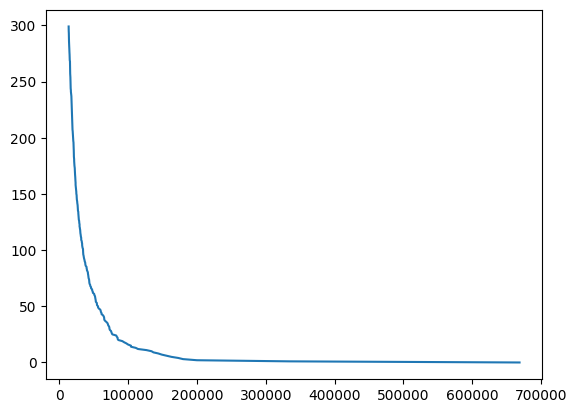

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(word_freq_lemmas.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [115]:
from nltk.tokenize import word_tokenize
#nltk.download('punkt') # закомментировал лишнюю команду
from string import punctuation

In [42]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 153499/153499 [05:50<00:00, 438.10it/s]


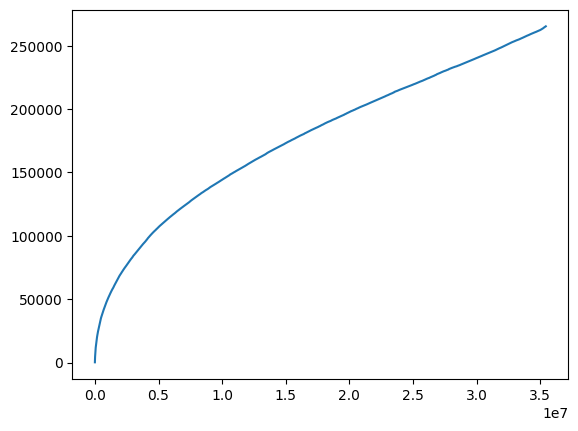

In [43]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

1.5. Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и "доверие"?

In [44]:
# Слово "клиент" встречает чаще слова "сотрудник"
word_freq_lemmas.get('сотрудник',0)>word_freq_lemmas.get('клиент',0)

False

In [45]:
word_freq_lemmas.get('мошеничество',0)

23

In [46]:
word_freq_lemmas.get('доверие',0)

2108

1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру Tf-idf
, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [49]:
def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "

In [50]:
%%time
df.text = df.text.apply(remove_stopwords)
df.text = df.text.apply(lemmatize)

CPU times: total: 48min 43s
Wall time: 49min 48s


In [51]:
df_positive = df[df['rating_grade'] == 5]

In [52]:
df_negative = df[df['rating_grade'] == 1]

#### Первый способ

In [53]:
corpus_positive = [tex_pos for tex_pos in tqdm(df_positive.text)]

100%|██████████| 14713/14713 [00:00<00:00, 1659873.98it/s]


In [54]:
tfidf_pos = TfidfVectorizer()

In [55]:
tfidf_pos.fit(corpus_positive)

TfidfVectorizer()

In [56]:
# Считаем средние значения TF-IDF для каждого слова по всей коллекции позитивных текстов
mean_tfidf_pos = tfidf_pos.transform(corpus_positive).mean(axis=0)

# Получаем индексы слов с наибольшими значениями TF-IDF
top_indices_pos = mean_tfidf_pos.argsort()[0, ::-1][:10]

# Получаем список ключевых слов
keywords_pos = tfidf_pos.get_feature_names_out()[top_indices_pos]

print("Ключевые слова для текстов с позитивным настроем:", keywords_pos)

Ключевые слова для текстов с позитивным настроем: [['банк' 'карта' 'вклад' ... 'парашют' 'сгнить' 'благоустроенный']]


In [57]:
pd.DataFrame(keywords_pos).T[:10]

,0
0,банк
1,карта
2,вклад
3,кредит
4,очень
5,отделение
6,это
7,день
8,клиент
9,сотрудник


#### Второй способ

In [58]:
tfIdfVectorizer_positive = TfidfVectorizer(use_idf = True)

In [59]:
tfIdf_positive = tfIdfVectorizer_positive.fit_transform(df_positive.text)

In [60]:
pd.DataFrame([tfIdfVectorizer_positive.get_feature_names_out(),tfIdfVectorizer_positive.idf_]).\
            T.sort_values(1).head(10)

,0,1
1370,банк,1.088334
35432,это,1.598913
19943,очень,1.60139
6251,день,1.69696
11056,клиент,1.711944
10670,карта,1.769527
11957,который,1.807352
29509,сотрудник,1.822706
5354,год,1.829849
19332,отделение,1.837514


#### Первый способ

In [61]:
corpus_negative = [tex_neg for tex_neg in tqdm(df_negative.text)]

100%|██████████| 47387/47387 [00:00<00:00, 1923874.59it/s]


In [62]:
tfidf_neg = TfidfVectorizer()

In [63]:
tfidf_neg.fit(corpus_negative)

TfidfVectorizer()

In [64]:
# Считаем средние значения TF-IDF для каждого слова по всей коллекции негативных текстов
mean_tfidf_neg = tfidf_neg.transform(corpus_negative).mean(axis=0)

# Получаем индексы слов с наибольшими значениями TF-IDF
top_indices_neg = mean_tfidf_neg.argsort()[0, ::-1][:10]

# Получаем список ключевых слов
keywords_neg = tfidf_neg.get_feature_names_out()[top_indices_neg]

print("Ключевые слова для текстов с негативным настроем:", keywords_neg)

Ключевые слова для текстов с негативным настроем: [['банк' 'карта' 'деньга' ... 'правопреемство' 'никнуть' 'взыскиваеться']]


In [65]:
pd.DataFrame(keywords_neg).T[:10]

,0
0,банк
1,карта
2,деньга
3,кредит
4,отделение
5,день
6,это
7,счёт
8,мой
9,заявление


#### Второй способ

In [66]:
tfIdfVectorizer_negative = TfidfVectorizer(use_idf = True)
tfIdf_negative = tfIdfVectorizer_negative.fit_transform(df_negative.text)

In [67]:
pd.DataFrame([tfIdfVectorizer_negative.get_feature_names_out(),tfIdfVectorizer_negative.idf_]).\
            T.sort_values(1).head(10)

,0,1
2177,банк,1.101761
56109,это,1.448047
9981,день,1.522635
18998,который,1.612851
22945,мой,1.629741
9982,деньга,1.656029
17047,карта,1.71564
45272,сказать,1.723092
30790,отделение,1.732793
17638,клиент,1.749621


### А теперь для биграмм первым способом

In [68]:
tfidf_pos = TfidfVectorizer(ngram_range=(2, 2))

In [69]:
tfidf_pos.fit(corpus_positive)

TfidfVectorizer(ngram_range=(2, 2))

In [70]:
mean_tfidf_pos = tfidf_pos.transform(corpus_positive).mean(axis=0)

top_indices_pos = mean_tfidf_pos.argsort()[0, ::-1][:10]

feature_names_pos = tfidf_pos.get_feature_names_out()
bigram_keywords_pos = [feature_names_pos[idx] for idx in top_indices_pos]

print("Ключевые биграммы для текстов с positive настроем:", bigram_keywords_pos)

Ключевые биграммы для текстов с positive настроем: [array([['интернет банк', 'кредитный карта', 'сотрудник банк', ...,
        'такой плавать', 'жильё иметь', 'действовать результат']],
      dtype=object)]


In [71]:
pd.DataFrame(bigram_keywords_pos[0]).T[:10]

,0
0,интернет банк
1,кредитный карта
2,сотрудник банк
3,другой банк
4,клиент банк
5,отделение банк
6,являться клиент
7,следующий день
8,альфа банк
9,открыть вклад


In [72]:
tfidf_neg = TfidfVectorizer(ngram_range=(2, 2))

In [73]:
tfidf_neg.fit(corpus_negative)

TfidfVectorizer(ngram_range=(2, 2))

In [74]:
mean_tfidf_neg = tfidf_neg.transform(corpus_negative).mean(axis=0)

top_indices_neg = mean_tfidf_neg.argsort()[0, ::-1][:10]

feature_names_neg = tfidf_neg.get_feature_names_out()
bigram_keywords_neg = [feature_names_neg[idx] for idx in top_indices_neg]

print("Ключевые биграммы для текстов с негативным настроем:", bigram_keywords_neg)

Ключевые биграммы для текстов с негативным настроем: [array([['сотрудник банк', 'кредитный карта', 'денежный средство', ...,
        'исполнять подписать', 'недопущение опись', 'ребёнок удивиться']],
      dtype=object)]


In [75]:
pd.DataFrame(bigram_keywords_neg[0]).T[:10]

,0
0,сотрудник банк
1,кредитный карта
2,денежный средство
3,отделение банк
4,написать заявление
5,горячий линия
6,ваш банк
7,колл центр
8,рабочий день
9,альфа банк


### Тематическое моделирование

In [76]:
#pip install gensim

In [77]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

##### 2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем

In [78]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [79]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [80]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: total: 1min 35s
Wall time: 1min 15s


In [81]:
lsi.show_topics(10)

[(0,
  '0.192*"карта" + 0.131*"кредит" + 0.114*"деньга" + 0.108*"заявление" + 0.106*"счёт" + 0.100*"вклад" + 0.099*"банкомат" + 0.099*"отделение" + 0.096*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.447*"вклад" + 0.341*"кредит" + -0.169*"банкомат" + 0.155*"платёж" + 0.154*"страховка" + 0.149*"задолженность" + -0.139*"карта" + 0.138*"погашение" + -0.119*"очередь" + -0.113*"открыть"'),
 (2,
  '-0.444*"вклад" + 0.283*"банкомат" + 0.240*"карта" + 0.208*"сбербанк" + -0.180*"кредит" + -0.134*"договор" + 0.134*"операция" + 0.130*"заявление" + 0.126*"деньга" + 0.123*"средство"'),
 (3,
  '-0.276*"вклад" + -0.216*"сумма" + 0.192*"номер" + 0.191*"заявка" + -0.187*"руб" + -0.156*"платёж" + -0.155*"договор" + -0.154*"погашение" + -0.146*"рубль" + 0.145*"звонок"'),
 (4,
  '-0.445*"карта" + 0.265*"банкомат" + -0.197*"лимит" + -0.184*"кредитный" + 0.172*"номер" + 0.142*"вклад" + 0.129*"звонок" + 0.119*"терминал" + 0.118*"деньга" + 0.112*"купюра"'),
 (5,
  '-0.341*"банкомат" + 0.277*"вклад" + -0.239*"страх

In [82]:
%%time
lsi_5 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

CPU times: total: 1min 21s
Wall time: 1min 8s


In [83]:
lsi_5.show_topics(5)

[(0,
  '0.192*"карта" + 0.132*"кредит" + 0.113*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.099*"вклад" + 0.099*"банкомат" + 0.099*"отделение" + 0.095*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.479*"вклад" + 0.327*"кредит" + 0.161*"страховка" + 0.146*"платёж" + 0.145*"задолженность" + 0.134*"погашение" + -0.130*"очередь" + -0.128*"банкомат" + -0.120*"открыть" + -0.119*"карта"'),
 (2,
  '-0.392*"вклад" + 0.267*"карта" + 0.263*"банкомат" + -0.215*"кредит" + 0.203*"сбербанк" + -0.148*"страховка" + 0.141*"операция" + -0.136*"договор" + 0.129*"средство" + 0.125*"деньга"'),
 (3,
  '-0.273*"вклад" + -0.211*"сумма" + 0.204*"номер" + 0.194*"заявка" + -0.182*"руб" + -0.167*"договор" + 0.163*"звонок" + -0.152*"платёж" + -0.146*"погашение" + -0.145*"средство"'),
 (4,
  '0.290*"вклад" + 0.274*"номер" + 0.231*"звонок" + -0.213*"страховка" + -0.192*"заявка" + 0.168*"ваш" + 0.147*"поступать" + 0.141*"персональный" + 0.138*"данные" + 0.131*"база"')]

In [84]:
%%time
lsi_3 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=3)

CPU times: total: 1min 22s
Wall time: 1min 9s


In [85]:
lsi_3.show_topics(3)

[(0,
  '0.192*"карта" + 0.132*"кредит" + 0.113*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.099*"банкомат" + 0.099*"отделение" + 0.099*"вклад" + 0.096*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.565*"вклад" + 0.232*"кредит" + -0.151*"очередь" + 0.139*"номер" + 0.135*"задолженность" + -0.134*"открыть" + 0.134*"звонок" + 0.129*"платёж" + 0.103*"погашение" + 0.102*"ваш"'),
 (2,
  '0.385*"банкомат" + -0.245*"вклад" + 0.225*"карта" + -0.201*"кредит" + 0.199*"сбербанк" + 0.174*"деньга" + -0.156*"звонок" + 0.146*"операция" + 0.128*"средство" + 0.119*"заявление"')]

##### 2.2. Приведите примеры понятных (интерпретируемых) тем

#### Интерпретируемые темы:  
* Тема 0 интерпретируется как получение кредитной карты
* Тема 1 интерпретируется как погашение задоженности по кредиту
* Тема 2 интерпретируется как операция с картой в банкоматах сбербанка

##### 2.3. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [86]:
%%time
lsi_25 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=25)

CPU times: total: 1min 44s
Wall time: 1min 25s


In [87]:
lsi_25.show_topics(25)

[(0,
  '0.192*"карта" + 0.131*"кредит" + 0.113*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.100*"банкомат" + 0.099*"вклад" + 0.099*"отделение" + 0.095*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.392*"вклад" + 0.353*"кредит" + -0.206*"банкомат" + -0.167*"карта" + 0.163*"страховка" + 0.147*"задолженность" + 0.144*"платёж" + 0.138*"погашение" + -0.117*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.488*"вклад" + 0.282*"банкомат" + 0.222*"карта" + 0.186*"сбербанк" + -0.138*"кредит" + 0.135*"заявление" + 0.123*"операция" + 0.121*"деньга" + -0.120*"договор" + 0.118*"средство"'),
 (3,
  '-0.267*"вклад" + -0.220*"сумма" + 0.198*"номер" + -0.192*"руб" + 0.168*"заявка" + -0.159*"погашение" + -0.156*"договор" + -0.156*"платёж" + 0.151*"звонок" + -0.146*"процент"'),
 (4,
  '0.327*"вклад" + -0.271*"карта" + 0.261*"номер" + -0.207*"страховка" + -0.192*"заявка" + 0.185*"звонок" + -0.142*"кредит" + 0.137*"ваш" + 0.133*"телефон" + -0.131*"лимит"'),
 (5,
  '0.475*"банкомат" + -0.359*"карта" + 0.159*"купюра" + 0

#### Темы с упоминаемыми банками:  
* Тема 2 по операциям с картой в банкоматах сбербанка. Не удивительно в связи с большой долей сбербанка в России, поэтому много вопросов.
* Тема 13 по операциям через терминал с кошельком Киви. В своё время распространённая денежная система.
* Тема 17 по операциям через терминал альфа-банка по кредитной карте. Были какие-то претензии.

### Классификация текстов

##### Будем классифицировать на два класса, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)

##### 3.1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое

In [88]:
print(f'Число строк с позитивным отзывом = {df_positive.shape[0]},\n\
Число строк с негативным отзывом = {df_negative.shape[0]}')

Число строк с позитивным отзывом = 14713,
Число строк с негативным отзывом = 47387


In [89]:
N1, N2 = 7000, 23000

In [90]:
df_cl = pd.concat([df_positive[:N1],df_negative[:N2]], ignore_index=True)

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
df_cl.head()

,city,bank_name,rating_grade,text,text_only_words
0,г. Санкт-Петербург,Русславбанк,5.0,досрочно закрывать вклад отпуск жена заказыват...,"[досрочно, закрывали, вклады, перед, отпуском,..."
1,г. Нижний Новгород,РосинтерБанк,5.0,хотеть открыть вклад доходный год процент начи...,"[хотел, открыть, вклад, доходный, под, год, пр..."
2,г. Москва,ВТБ 24,5.0,вчера июнь просидеть очередь х час получение с...,"[вчера, июня, просидев, в, очереди, более, х, ..."
3,г. Москва,Соверен Банк,5.0,сегодня открывать вклад банк очередь один клие...,"[сегодня, открывал, вклад, в, этом, банке, оче..."
4,г. Москва,Ренессанс Кредит,5.0,история получение кредит ренессанс кредит банк...,"[моя, история, получения, кредита, в, ренессан..."


In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_cl.text, df_cl.rating_grade,\
                                                    test_size=0.2, random_state=42)

##### 3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

In [95]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

pred = clf.predict(X_test_tfidf)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       1.00      0.84      0.91      5517
         5.0       0.35      1.00      0.52       483

    accuracy                           0.85      6000
   macro avg       0.68      0.92      0.72      6000
weighted avg       0.95      0.85      0.88      6000



##### 3.3. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.

In [96]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)

In [97]:
type(bow)

scipy.sparse._csr.csr_matrix

In [98]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [99]:
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98      4659
         5.0       0.91      0.93      0.92      1341

    accuracy                           0.96      6000
   macro avg       0.94      0.95      0.95      6000
weighted avg       0.96      0.96      0.96      6000



In [100]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.94      0.96      4889
         5.0       0.78      0.97      0.87      1111

    accuracy                           0.94      6000
   macro avg       0.89      0.95      0.92      6000
weighted avg       0.95      0.94      0.95      6000



In [101]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(X_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       1.00      0.82      0.90      5639
         5.0       0.26      0.97      0.40       361

    accuracy                           0.83      6000
   macro avg       0.63      0.90      0.65      6000
weighted avg       0.95      0.83      0.87      6000



##### 3.4. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: 
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),  
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

##### 3.5. Используйте accuracy и F-measure для оценки качества классификации.

In [102]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

###### 1-й вариант

In [103]:
vec = TfidfVectorizer()

In [104]:
X_train_tfidf = vec.fit_transform(X_train)
X_test_tfidf = vec.transform(X_test)

In [105]:
lsa = TruncatedSVD(n_components=20, random_state=0)

In [106]:
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

In [107]:
clf = LogisticRegression(random_state=42) #MultinomialNB()
clf.fit(X_train_lsa, y_train)

LogisticRegression(random_state=42)

In [108]:
pred = clf.predict(X_test_lsa)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.97      0.93      0.95      4864
         5.0       0.74      0.90      0.81      1136

    accuracy                           0.92      6000
   macro avg       0.86      0.91      0.88      6000
weighted avg       0.93      0.92      0.92      6000



###### 2-й вариант

In [109]:
vec = CountVectorizer()
X_train_counts = vec.fit_transform(X_train)
X_test_counts = vec.transform(X_test)

In [110]:
lda = LatentDirichletAllocation(n_components = 25, random_state = 42)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)

In [111]:
clf = LogisticRegression(random_state=42) #MultinomialNB()
clf.fit(X_train_lda, y_train)

LogisticRegression(random_state=42)

In [112]:
pred = clf.predict(X_test_lda)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96      4799
         5.0       0.80      0.91      0.85      1201

    accuracy                           0.94      6000
   macro avg       0.89      0.93      0.91      6000
weighted avg       0.94      0.94      0.94      6000



In [114]:
#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Total execution time: {.2} seconds".format(execution_time))